# Importamos bibliotecas necesarias

In [1]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Para importar Notebooks propias

##### Desde Jupyter no se importar archivos python planos, sino notebooks que tienen una codificación mas complicada. Para poder importar una notebook correctamente hay que agregar los siguientes métodos (tomado de https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html)

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

# Importamos biblioteca propia

In [7]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import Desafio_2_aux

importing Jupyter notebook from Desafio_2_aux.ipynb


# Leer el data set desde el archivo csv

In [8]:
pathArchivoDataSet = 'properatti_2.csv'
df = pd.read_csv(pathArchivoDataSet)

In [9]:
df.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
1,apartment,la plata,Bs.As. G.B.A. Zona Sur,150000.0,69.891566,0.0,2146.181693,3.0,-34.924277,-57.965973,0,1,1,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
4,apartment,centro,Buenos Aires Costa Atlántica,64000.0,35.000000,0.0,1828.571429,4.0,-38.000247,-57.547260,0,0,0,0,0


### Hacemos un análisis de la correlación entre las variables del data frame

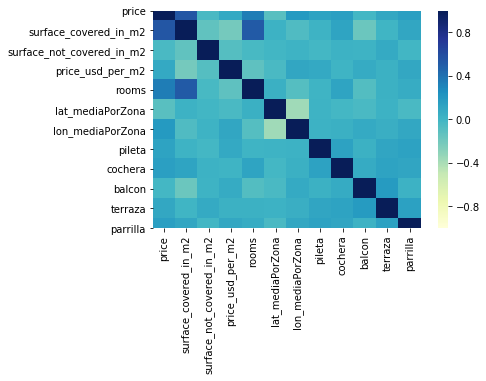

In [10]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu");

# Definimos el subset de datos del cual generaremos el modelo

### Nos quedamos con el subset de datos relacionados a Capital Federal

In [11]:
filtroParaElSubsetDeDatos = ['Santa Fe']

In [12]:
df_subset = Desafio_2_aux.getSubDataFrameByStateName(df, filtroParaElSubsetDeDatos)

Sub data frame Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8012 entries, 9 to 109205
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              8012 non-null   object 
 1   place_name                 8012 non-null   object 
 2   price                      8012 non-null   float64
 3   surface_covered_in_m2      8012 non-null   float64
 4   surface_not_covered_in_m2  8012 non-null   float64
 5   price_usd_per_m2           8012 non-null   float64
 6   rooms                      8012 non-null   float64
 7   lat_mediaPorZona           8012 non-null   float64
 8   lon_mediaPorZona           8012 non-null   float64
 9   pileta                     8012 non-null   int64  
 10  cochera                    8012 non-null   int64  
 11  balcon                     8012 non-null   int64  
 12  terraza                    8012 non-null   int64  
 13  parrilla               

# Analizamos outliers y los sacamos del data frame

### Vemos la distribucion de los datos en gráficos para tratar de identificar los outliers que tenemos

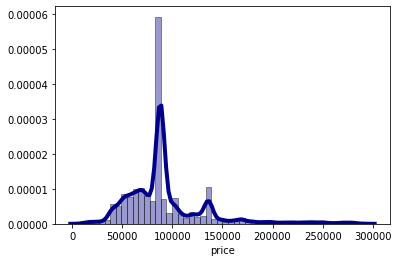

In [13]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price')


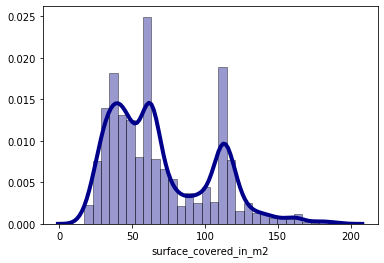

In [14]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_covered_in_m2')

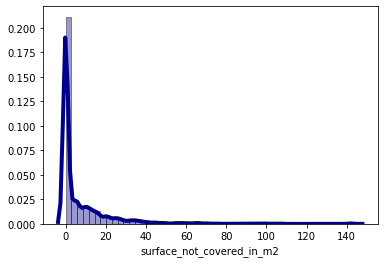

In [15]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_not_covered_in_m2')

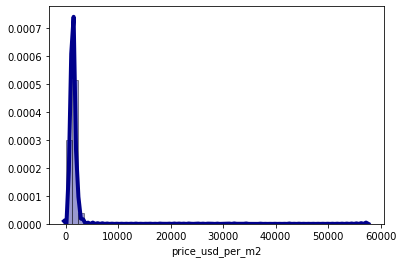

In [16]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

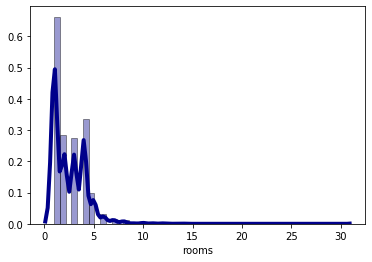

In [17]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

### Removemos los outliers

In [18]:
df_subset.describe()

,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
count,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000
mean,92092.907157,69.098438,7.307335,1665.470209,2.552297,-32.742832,-60.694002,0.093235,0.402022,0.304044,0.258487,0.214304
std,39784.305390,34.315078,14.725724,2997.072620,1.712485,0.538072,0.189931,0.290780,0.490337,0.460030,0.437830,0.410364
min,10095.060000,17.000000,0.000000,0.600000,1.000000,-38.416097,-63.616672,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69509.346937,41.000000,0.000000,966.602365,1.000000,-32.947316,-60.661852,0.000000,0.000000,0.000000,0.000000,0.000000
50%,88084.667471,62.285277,0.000000,1390.958081,2.000000,-32.947316,-60.661852,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100000.000000,100.000000,9.733355,1692.945102,4.000000,-32.947316,-60.661852,0.000000,1.000000,1.000000,1.000000,0.000000
max,290000.000000,190.000000,144.000000,57382.080000,30.000000,-29.156925,-58.333860,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#removemos datos por outliers de precio por m2
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'price_usd_per_m2', 500, 2500)

In [20]:
#removemos outliers por rooms
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'rooms', 1, 5)

In [21]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6757 entries, 0 to 6756
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              6757 non-null   object 
 1   place_name                 6757 non-null   object 
 2   price                      6757 non-null   float64
 3   surface_covered_in_m2      6757 non-null   float64
 4   surface_not_covered_in_m2  6757 non-null   float64
 5   price_usd_per_m2           6757 non-null   float64
 6   rooms                      6757 non-null   float64
 7   lat_mediaPorZona           6757 non-null   float64
 8   lon_mediaPorZona           6757 non-null   float64
 9   pileta                     6757 non-null   int64  
 10  cochera                    6757 non-null   int64  
 11  balcon                     6757 non-null   int64  
 12  terraza                    6757 non-null   int64  
 13  parrilla                   6757 non-null   int64

### Vemos como quedaron los datos

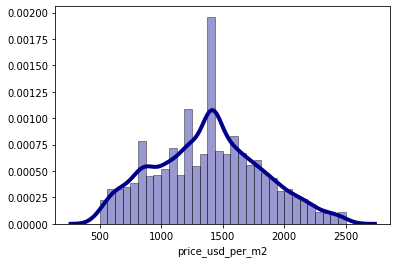

In [22]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

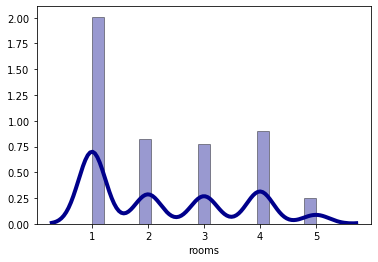

In [23]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

# Analizamos las variables categóricas

rosario                       5775
santa fe                       476
san lorenzo                     85
castellanos                     71
esperanza                       64
funes                           53
roldán                          44
rafaela                         29
reconquista                     19
villa constitución              18
granadero baigorria             18
capitán bermúdez                16
iriondo                         14
santo tomé                      10
las rosas                        8
san jorge                        6
ibarlucea                        5
avellaneda                       5
sauce viejo                      4
arocena                          4
san josé del rincón              3
coronda                          3
humboldt                         2
providencia                      2
arroyo leyes                     2
bella italia                     2
colastiné                        2
arequito                         1
pérez               

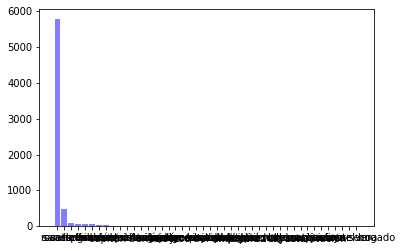

apartment    5423
house        1127
store         152
PH             55
Name: property_type, dtype: int64


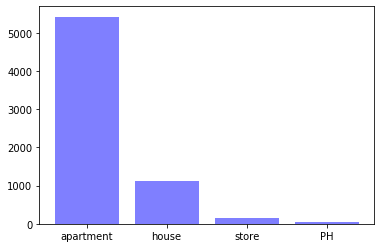

In [24]:
Desafio_2_aux.analyzeCategoricalData(df_subset, ['place_name', 'property_type'])

### Creamos variables dummies a partir de la variable categorica

In [25]:
df_subset = Desafio_2_aux.createDummiesForVariables(df_subset, ['place_name', 'property_type'])

In [26]:
df_subset.head()

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_santa fe,place_name_santo tomé,place_name_sauce viejo,place_name_serodino,place_name_sunchales,place_name_susana,place_name_villa constitución,property_type_apartment,property_type_house,property_type_store
0,apartment,rosario,88084.667471,55.000000,0.0,1601.539409,2.0,-32.947316,-60.661852,0,...,0,0,0,0,0,0,0,1,0,0
1,apartment,rosario,88084.667471,55.000000,0.0,1601.539409,2.0,-32.947316,-60.661852,0,...,0,0,0,0,0,0,0,1,0,0
2,apartment,rosario,88084.667471,63.000000,0.0,1398.169325,1.0,-32.947316,-60.661852,0,...,0,0,0,0,0,0,0,1,0,0
3,house,san lorenzo,109282.491200,125.000000,54.0,610.516711,5.0,-32.881885,-60.785617,0,...,0,0,0,0,0,0,0,0,1,0
4,house,santa fe,101939.337902,118.617021,0.0,859.398902,5.0,-31.678706,-60.705142,0,...,1,0,0,0,0,0,0,0,1,0


# Guardamos un data frame auxiliar con la relacion entre los dummies y el dato place_name

### Data frame auxiliar para place name

In [27]:
place_name_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'place_name')
place_name_dummies

,place_name,place_name_arequito,place_name_arocena,place_name_arroyo leyes,place_name_arroyo seco,place_name_avellaneda,place_name_bella italia,place_name_capitán bermúdez,place_name_castellanos,place_name_cayastá,...,place_name_san jorge,place_name_san josé del rincón,place_name_san lorenzo,place_name_santa fe,place_name_santo tomé,place_name_sauce viejo,place_name_serodino,place_name_sunchales,place_name_susana,place_name_villa constitución
0,rosario,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,san lorenzo,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,santa fe,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,reconquista,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,esperanza,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,rafaela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65,bella italia,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88,granadero baigorria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120,castellanos,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
134,funes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data frame auxiliar para property_type

In [28]:
proeprty_type_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'property_type')
proeprty_type_dummies

,property_type,property_type_apartment,property_type_house,property_type_store
0,apartment,1,0,0
3,house,0,1,0
15,PH,0,0,0
47,store,0,0,1


# Generamos el objeto para el K Fold

In [29]:
#generamos un K Fold de 5 pasos para el entrenamiento de los modelos
cv = KFold(5, shuffle=True, random_state=10)

# Quitamos las columnas que no van a estar en el modelo

In [30]:
#quitamos las columnas que no van a participar en el modelo
df_model_columns = df_subset.drop(labels= ["price", "property_type", "place_name"], axis=1)
df_model_columns

,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,...,place_name_santa fe,place_name_santo tomé,place_name_sauce viejo,place_name_serodino,place_name_sunchales,place_name_susana,place_name_villa constitución,property_type_apartment,property_type_house,property_type_store
0,55.000000,0.000000,1601.539409,2.0,-32.947316,-60.661852,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,55.000000,0.000000,1601.539409,2.0,-32.947316,-60.661852,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,63.000000,0.000000,1398.169325,1.0,-32.947316,-60.661852,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
3,125.000000,54.000000,610.516711,5.0,-32.881885,-60.785617,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,118.617021,0.000000,859.398902,5.0,-31.678706,-60.705142,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6752,33.000000,0.000000,1699.505152,1.0,-32.947316,-60.661852,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6753,25.000000,2.000000,1744.825185,1.0,-32.947316,-60.661852,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
6754,34.000000,6.000000,2202.116687,1.0,-32.947316,-60.661852,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6755,91.000000,0.000000,1098.901099,4.0,-32.947316,-60.661852,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Análisis de correlación entre los datos

In [31]:
Desafio_2_aux.showCorrelatedData(df_model_columns, -0.5, 0.5)

surface_covered_in_m2                  surface_covered_in_m2                    1.000000
                                       rooms                                    0.598505
                                       property_type_house                      0.614602
surface_not_covered_in_m2              surface_not_covered_in_m2                1.000000
price_usd_per_m2                       price_usd_per_m2                         1.000000
rooms                                  surface_covered_in_m2                    0.598505
                                       rooms                                    1.000000
lat_mediaPorZona                       lat_mediaPorZona                         1.000000
                                       place_name_santa fe                      0.660615
lon_mediaPorZona                       lon_mediaPorZona                         1.000000
pileta                                 pileta                                   1.000000
cochera              

En el modelo se detectan las siguientes correlaciones:

surface_covered_in_m2---rooms                             
surface_covered_in_m2---property_type_house
surface_covered_in_m2---property_type_apartment   
lat_mediaPorZona--place_name_santa fe
lat_mediaPorZona---place_name_rosario
lon_mediaPorZona---place_name_castellanos
place_name_santa fe---place_name_rosario

In [32]:
#eliminamos una de las columnas de los pares de correlacion
df_model_columns_no_corr = df_model_columns.drop(labels=['rooms','property_type_house','property_type_apartment',\
                                                        'place_name_santa fe','place_name_rosario','place_name_castellanos'], axis=1)

# Generamos un modelo con Regresion Lineal

In [54]:
#definimos como variables para entrenamiento todas las del data frame excepto el precio por m2
#el valor precio por m2 será lo que el modelo intente calcular
X = df_model_columns_no_corr.drop('price_usd_per_m2', axis=1)
y = df_model_columns_no_corr['price_usd_per_m2']

In [58]:
#seleccionamos un tamaño para el set de test del 1% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=10)

### Realizamos un entrenamiento con el k fold con k = 5

In [59]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
regresionLineal_model, regresionLineal_predicciones, df_regresion_lineal_prediccion_vs_real, scores_lineal = \
                Desafio_2_aux.generateSimpleLinearRegression(X_train, X_test, y_train, y_test, cv)

Score regresión lineal con 5-fold: [-5.26040710e+22 -1.49899788e+26 -1.17478814e+23 -3.96883184e+24
 -1.28455377e+25]



Intercept: 
1385.0314111073176



Coeficientes: 
[-2.22693482e+02 -1.28526841e+02 -8.68001087e+01 -4.23891688e+01
  1.76058974e+01  1.10467145e+01  2.11428716e+01 -7.38261318e+00
  8.62955975e+00 -1.58110513e+01  2.04213214e+00  4.39378334e+00
  3.70710434e-02  7.35686316e+00  5.43303549e-01 -7.68046712e+00
  5.14483942e+00 -5.02034633e-01 -2.53031355e-01  4.31120398e-01
 -2.47377552e+00 -2.57324672e+01  1.53316237e+01 -5.36172270e+00
  5.46589362e+00  2.08299988e+00  7.37051106e+00 -8.59471973e+00
  2.81850868e+00 -1.43916199e+01  7.73274589e-01 -2.02450552e+00
  1.88446195e+01  1.74998771e+00 -7.44117544e+00 -1.96713860e+01
  3.89569539e+01 -1.48428003e+01 -1.09042860e+01  1.45432002e+01
 -8.95642061e-01  3.92739311e+00 -9.19128148e+00 -6.60188835e-01
  2.06589150e+00 -3.57881108e+00  9.38637186e-01 -1.27403988e-01
 -1.71047583e+01  1.20593700e+01]



MAE: 251.3928

In [57]:
df_regresion_lineal_prediccion_vs_real

,Real,Predichos,Diferencia
2993,1762.629762,1321.864887,440.764875
191,2199.908652,1313.337810,886.570842
139,1228.004507,1160.621211,67.383297
2279,1144.574333,1036.670287,107.904046
5859,1247.204224,1003.992761,243.211463
...,...,...,...
4429,1797.646275,1588.846279,208.799995
5891,1465.517241,1502.171416,-36.654174
2310,1132.075472,1152.478891,-20.403420
1361,1561.248108,1723.706036,-162.457928


# Redefinimos los data frames para modelar, ya que ahora necesitamos un subconjunto de prueba sobre el data frame total

In [37]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Generamos el modelo para Ridge Cross Validation

In [38]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
model_ridge, RidgeCV_predicciones, df_ridge_prediccion_vs_real, model_ridge_score = \
                Desafio_2_aux.generateRidgeCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

Score Ridge CV: [0.41586579 0.37637638 0.38372483 0.41207824 0.4239704 ]
Alpha Ridge CV: 1.0
Coeficientes:  [-2.21906342e+02 -1.30954643e+02 -9.91412016e+01 -5.12417583e+01
  1.74969057e+01  1.39808900e+01  2.04981751e+01 -4.96794384e+00
  5.46691086e+00 -2.25346929e+01  1.96223449e+00  4.09096344e+00
  1.14949224e-01  9.95648728e+00  5.70964113e-01 -1.01340758e+01
  6.81324596e+00  2.15850131e+00  1.30217032e+00  0.00000000e+00
 -2.90411539e+00 -2.18708986e+01  1.51891692e+01 -5.16741964e+00
  0.00000000e+00  2.67120808e+00  6.26772535e+00 -1.11502871e+01
  3.66225374e+00 -1.81366610e+01  1.30200965e+00 -2.24719874e+00
  1.58084420e+01  2.26580283e+00 -8.71139270e+00 -1.73219657e+01
  4.75467372e+01 -1.79960284e+01 -1.44545824e+01  0.00000000e+00
 -2.35079429e+00  3.67480002e+00 -4.40130319e+00  2.52178287e+00
  2.18174986e+00  0.00000000e+00  1.08638307e+00 -2.94852150e-01
 -1.60442683e+01  1.13975072e+01]
MAE: 249.53903762763906
MSE: 112525.84709596493
RMSE: 335.44872498783616
R2: 0

In [39]:
df_ridge_prediccion_vs_real

,Real,Predichos,Diferencia
2993,1762.629762,1328.136041,434.493721
191,2199.908652,1316.352113,883.556538
139,1228.004507,1173.015439,54.989069
2279,1144.574333,1043.924416,100.649918
5859,1247.204224,1008.803679,238.400545
...,...,...,...
6423,859.398902,832.118379,27.280524
3545,1797.646275,1612.016818,185.629457
1598,1957.437055,1596.134845,361.302210
121,1399.413968,1406.330672,-6.916704


# Generamos el modelo para Lasso Cross Validation

In [40]:
model_lasso, LassoCV_predicciones, df_lasso_prediccion_vs_real, scores_lasso = \
        Desafio_2_aux.generateLassoCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureW




Intercept: 



1389.5864849266065



Coeficientes: 



[-2.21300429e+02 -1.28838584e+02 -8.16923648e+01 -2.32257616e+01
  1.60942999e+01  1.17873339e+01  1.91615340e+01 -1.20520517e+00
  3.42219137e+00 -1.02282123e+01  0.00000000e+00  8.30802835e-01
 -0.00000000e+00 -0.00000000e+00  3.47693569e-02 -7.74524237e+00
  2.47443142e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.15650948e+00 -2.03988305e+01  1.58049848e+01 -2.70376209e+00
  0.00000000e+00  8.61060415e-01  4.64011703e+00 -7.19259189e+00
  7.32605279e-01 -1.02612070e+01  0.00000000e+00 -0.00000000e+00
  1.35379710e+01  3.90338863e-02 -6.01406043e+00 -9.80942120e+00
  2.89351906e+01 -1.22881066e+01 -6.73543252e+00  0.00000000e+00
  1.34765699e+00  5.86617674e-01 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.49908002e-01  0.00000000e+00
 -1.60691424e+01  9.05997246e+00]



MAE: 250.07617119061842
MSE: 111403.91076642692
RMSE: 333.7722438526411
R2: 0.39902233283462996


##### Vemos que el modelo lasso seleccionó algunos coeficientes para no ser incluidos en el modelo, aquellos que valen 0

In [60]:
model_lasso.alpha_

2.1317675773638705

In [ ]:
df_lasso_prediccion_vs_real

# Verificamos los resultados

### Visualizamos los scores de los modelos

In [42]:
print("Score Train Lineal: " ,scores_lineal)
print("Score Train Ridge: " , model_ridge_score)
print("Score Train Lasso: " ,  scores_lasso)

Score Train Lineal:  [-5.26040710e+22 -1.49899788e+26 -1.17478814e+23 -3.96883184e+24
 -1.28455377e+25]
Score Train Ridge:  [0.41586579 0.37637638 0.38372483 0.41207824 0.4239704 ]
Score Train Lasso:  [0.41443618 0.37316833 0.3894124  0.41568281 0.42470109]


### Visualizamos los errores cuadraticos medios

In [43]:
print("Test RMSE Lineal: " + str(np.sqrt(metrics.mean_squared_error(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))))
print("Test RMSE RidgeCV: " + str(np.sqrt(metrics.mean_squared_error(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))))
print("Test RMSE Lasso: " + str(np.sqrt(metrics.mean_squared_error(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))))

Test RMSE Lineal: 341.43055215563993
Test RMSE RidgeCV: 335.44872498783616
Test RMSE Lasso: 333.7722438526411


In [44]:
print ('Test R2 Lineal:', metrics.r2_score(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))
print ('Test R2 RidgeCV:', metrics.r2_score(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))
print ('Test R2 Lasso:', metrics.r2_score(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))

Test R2 Lineal: 0.46048641373497146
Test R2 RidgeCV: 0.39296995394240686
Test R2 Lasso: 0.39902233283462996


### Visualizamos en histogramas como aportan los coeficientes en cada modelo

### Coeficientes de la Regresion Lineal

In [45]:
df_coeficientes_lineal = Desafio_2_aux.generateDataFrameFromModelCoeficients(regresionLineal_model.coef_, X.columns)

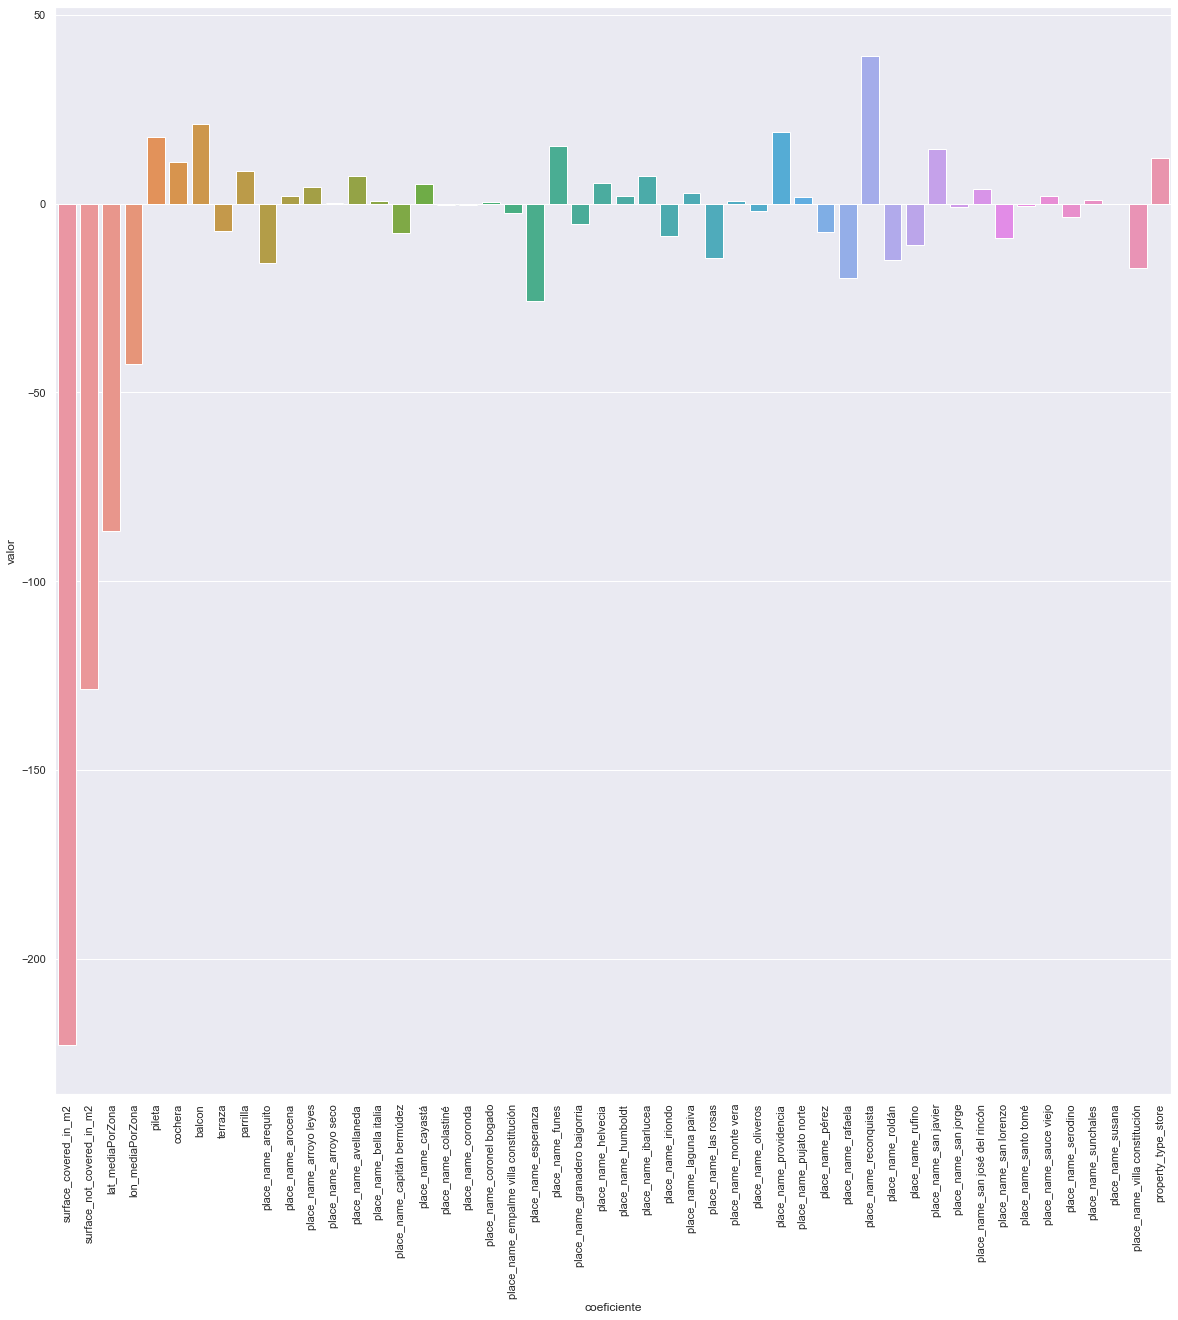

In [46]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lineal);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes RidgeCV

In [47]:
df_coeficientes_ridge = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_ridge.coef_, X.columns)

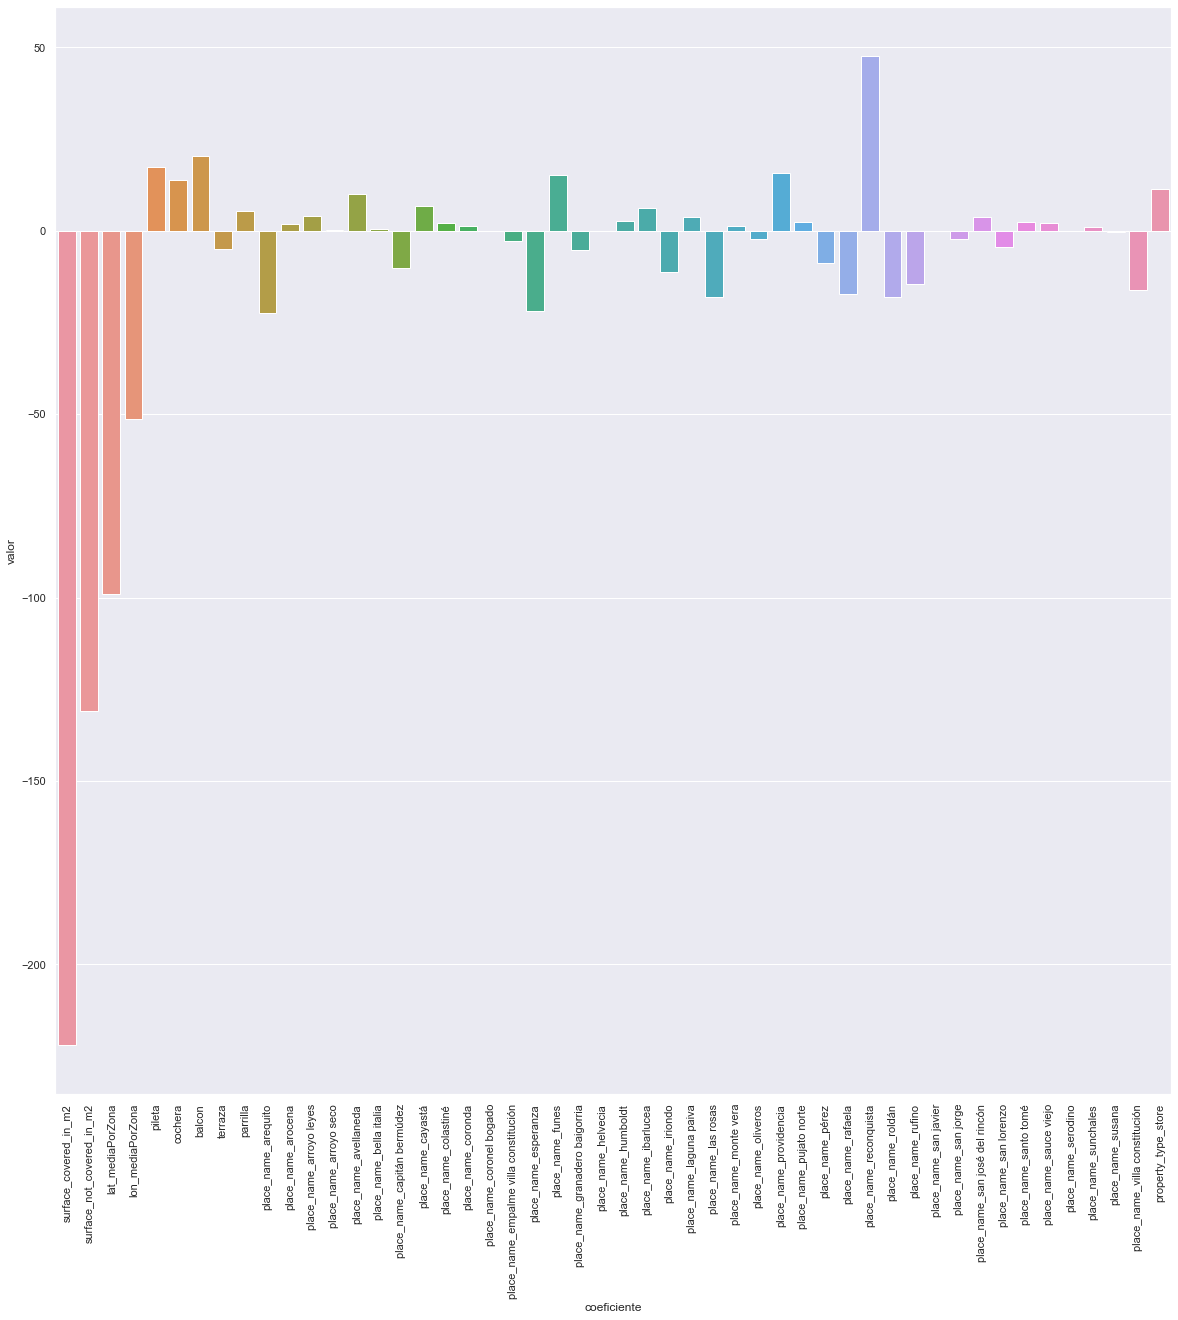

In [48]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_ridge);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes para el modelo Lasso

In [49]:
df_coeficientes_lasso = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_lasso.coef_, X.columns)

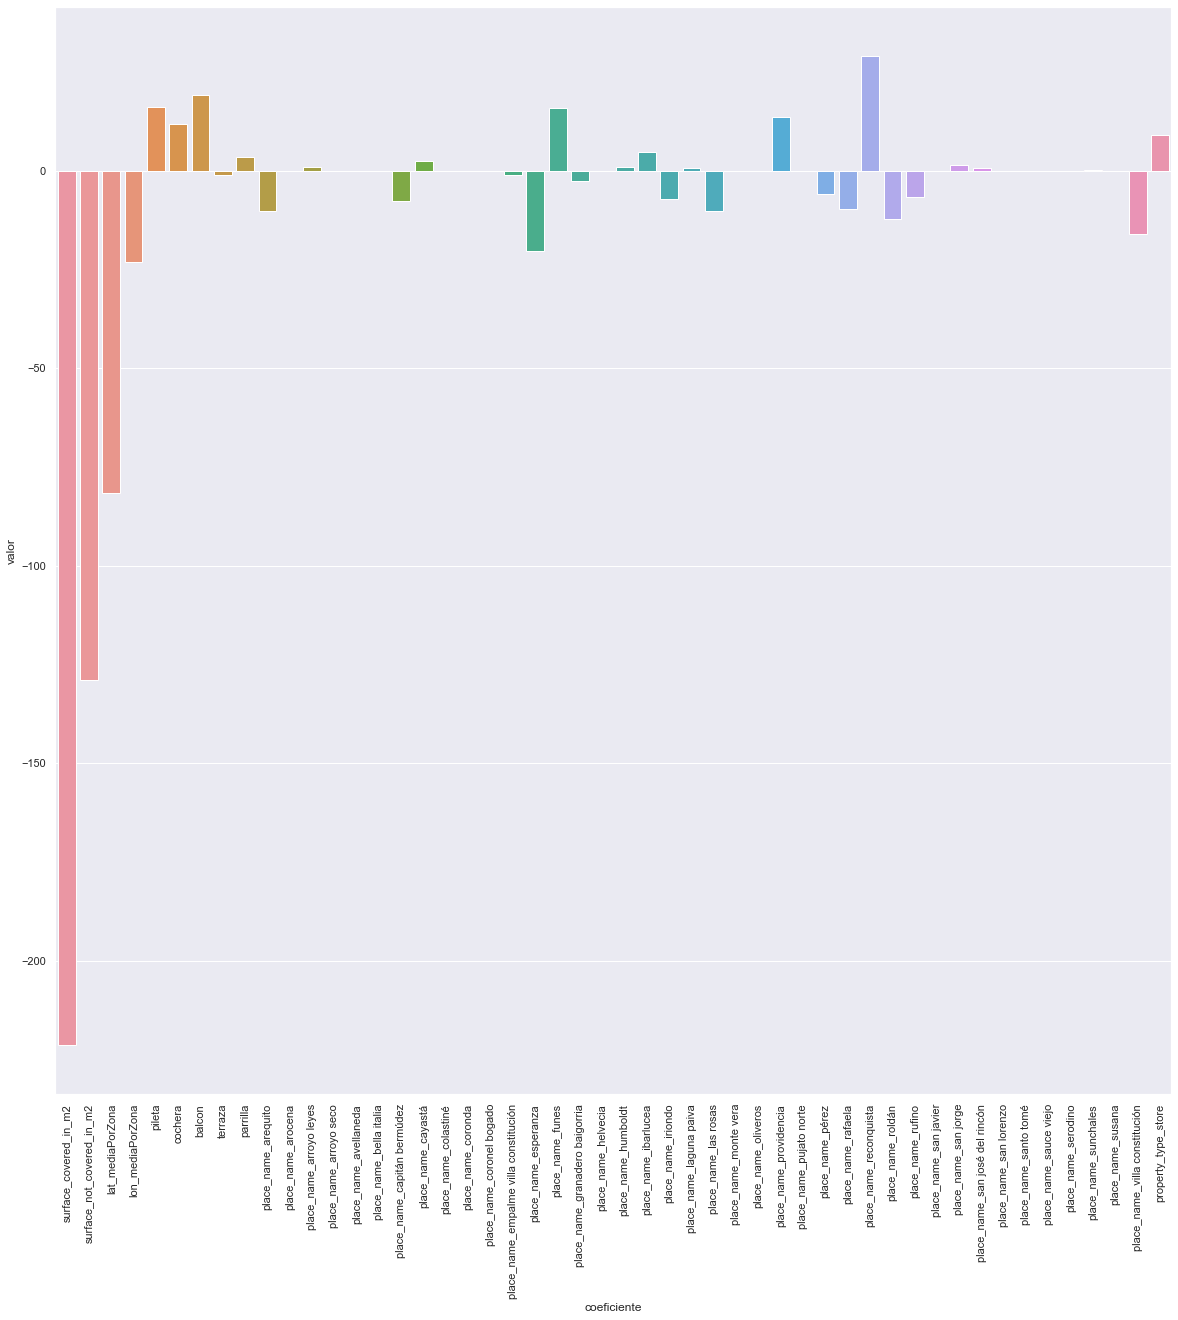

In [50]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lasso);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

# Veamos como quedaron las relaciones entre los resultados predichos VS los resultados esperados

### Regresion Lineal

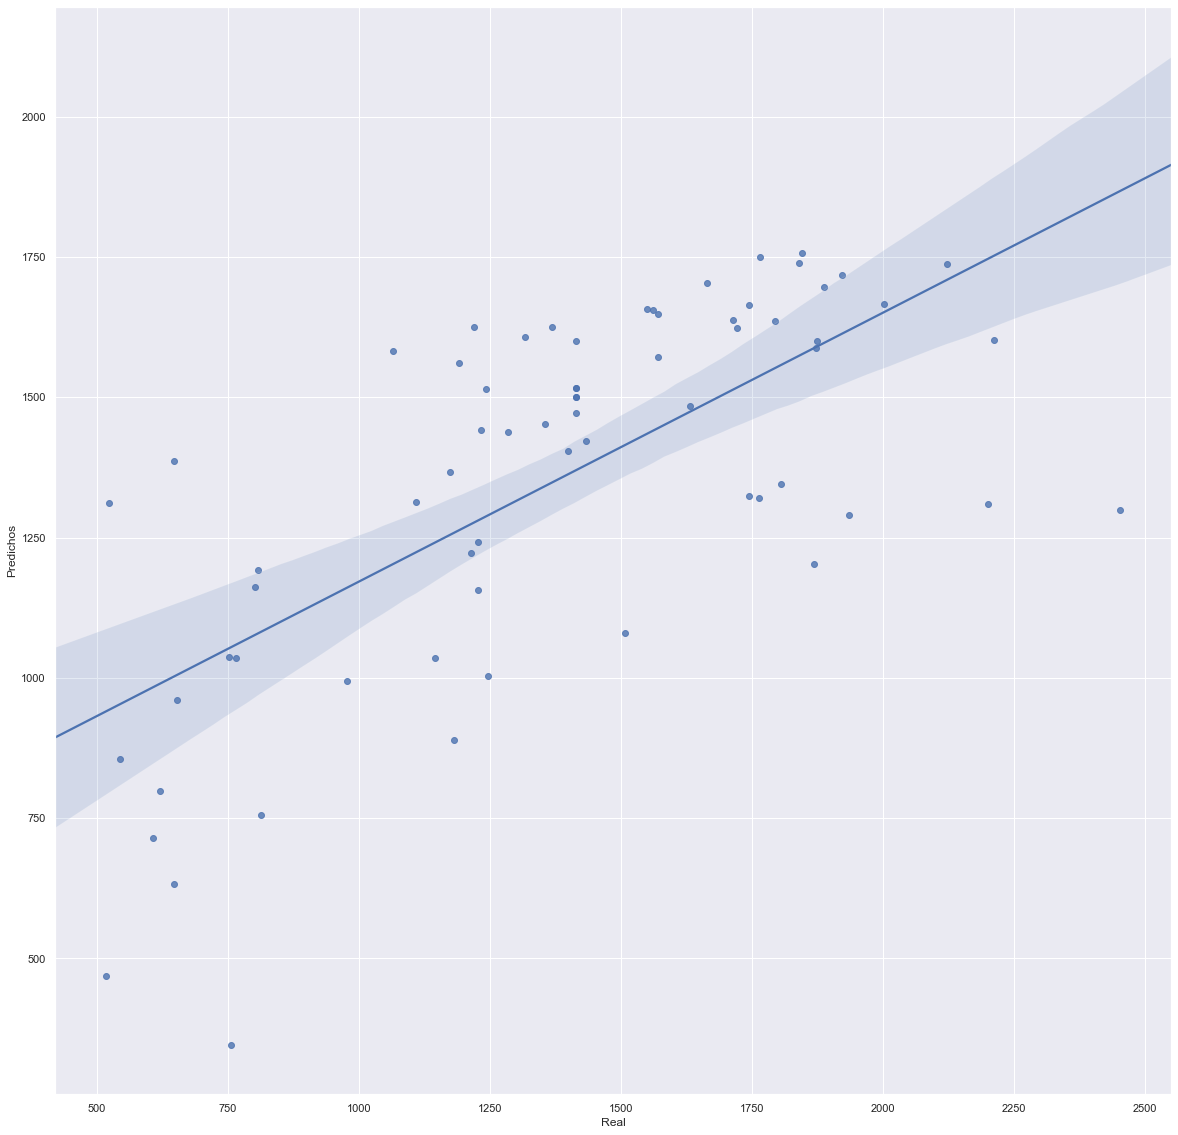

In [51]:
sns.regplot(df_regresion_lineal_prediccion_vs_real['Real'], df_regresion_lineal_prediccion_vs_real['Predichos'])

### Ridge CV

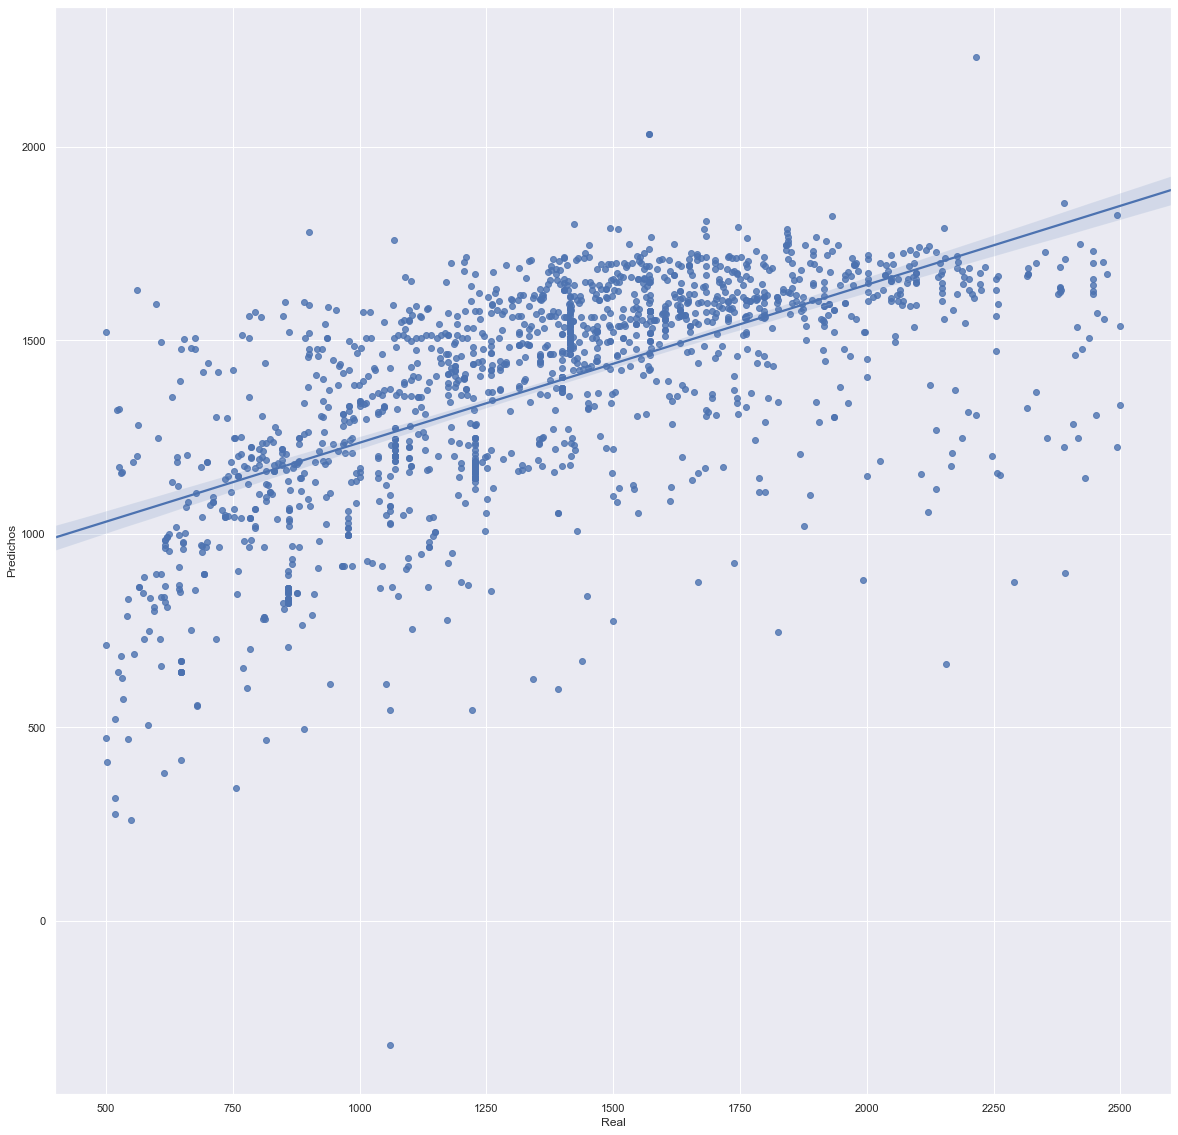

In [52]:
sns.regplot(df_ridge_prediccion_vs_real['Real'], df_ridge_prediccion_vs_real['Predichos'])

### Lasso

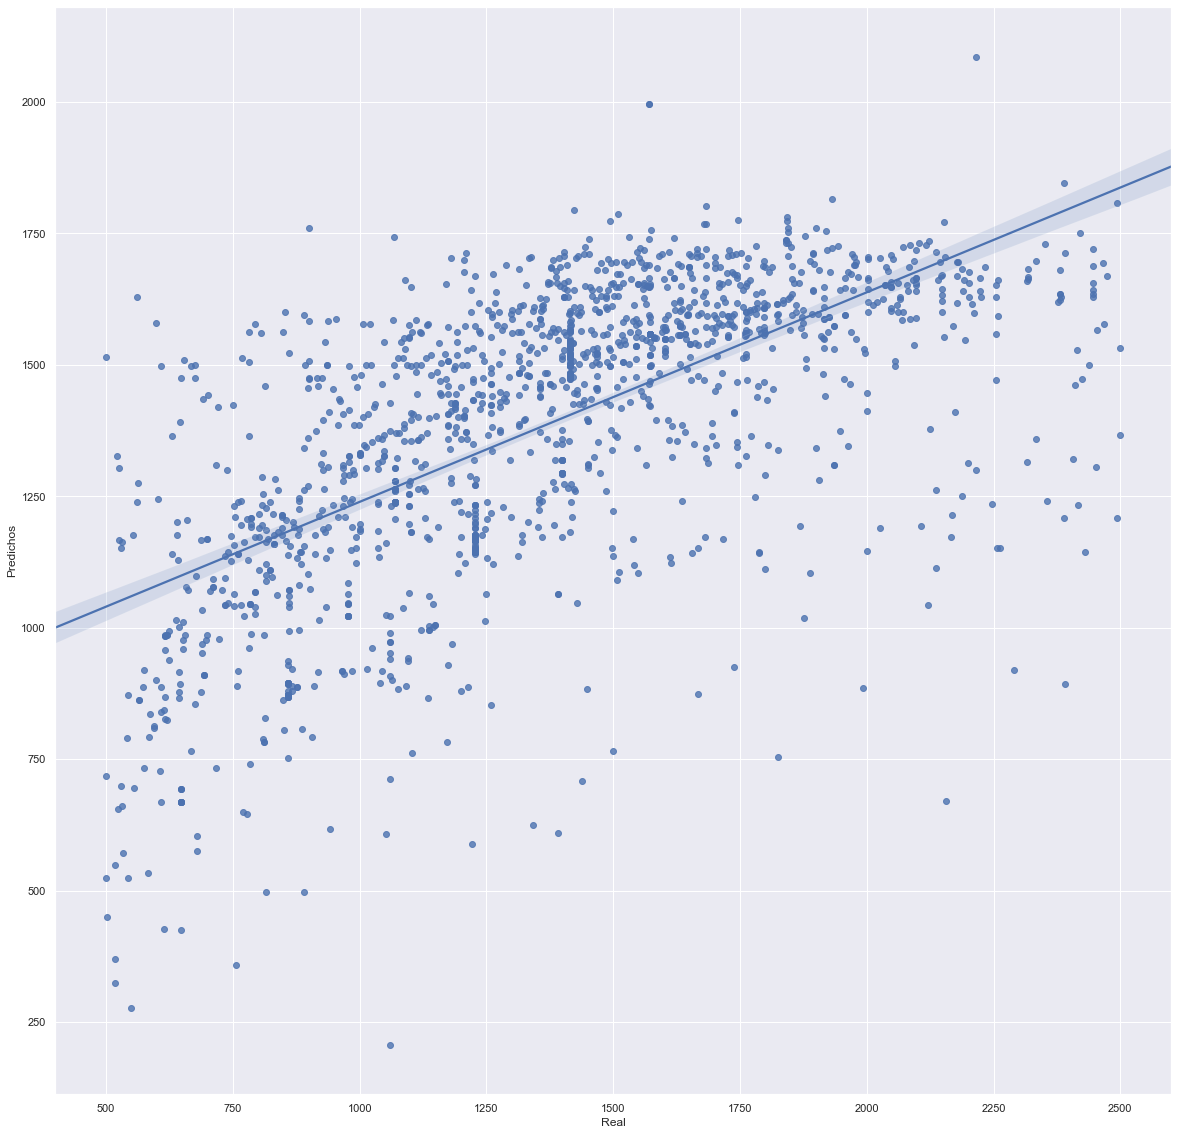

In [53]:
sns.regplot(df_lasso_prediccion_vs_real['Real'], df_lasso_prediccion_vs_real['Predichos'])

Una posible mejora que se puede agregar al análisis es ver la diferencia entre los valores predichos vs los valores reales por barrio. Para eso es necesario, cuando se hace el split para el entrenamiento y el testeo, que seleccione subconjuntos de acuerdo a las cantidades de filas para cada barrio. Porque por ejemplo el barrio de Palermo tiene mas de 2000 registros en el dataset, mientras que hay otros barrios, como Parque Chas, que no superan los 20